
# COMP3411/9418 21T0 Assignment 2

- Lecturer: Anna Trofimova
- School of Computer Science and Engineering, UNSW Sydney
- Last Update 26th January at 07:00am, 2021
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$

## Student:
Hoya Lee, z5226463

### Submission
This interactive notebook contains the instructions to complete assignment 2; You should submit this notebook with the code and answers in one single file in .ipybn format with the name assignment2.ipybn. **Write your name and zID in the cell above** (to edit the markdown text double-click the cell).

There is a maximum file size cap of 5MB, so make sure your submission does not exceed this size. The submitted notebook should contain all your source code and answers. You can add new cells and use markdown text to organise and explain your implementation/answer.

Submit your files using give. On a CSE Linux machine, type the following on the command-line:

The submission deadline is **3rd February at 11.59pm, 2021.** This is a hard deadline, no extentions will be granted (it is not our decision, it is the reality of the summer term courses).

### Late Submission Policy 
The penalty is set at 20% per late day. This is a ceiling penalty, so if your submission is marked 12/20 and it was submitted two days late, you still get 12/20. If you submit 5 days later, then the penalty is 100% and your mark will be 0.

### Plagiarism
This is an individual assignment. Remember that **all** work submitted for this assignment must be your own **individual** work and no code
sharing or copying is allowed. You may use code from the Internet only with suitable attribution
of the source in your program. **Do not use public code repositories as your code might be copied.** Keep in mind that sharing parts of assignment solutions is a form of plagiarism. All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions. You should carefully read the UNSW policy on academic integrity and plagiarism. 

### Motivation

Imagine that you have been hired as a Data Scientist by Amazon, and your first task is to evaluate customer sentiment towards their products. Many online stores selling Amazon products provide their customers with an option to leave a review, but they might not have a rating system, or the customers might choose to leave a review without rating. However, you still want to use these reviews in your report. Thus, you need to develop a reliable model that can automatically assign setiment given a review.

To develop your model, you have been given a collection of customer reviews on products like Alexa Echo, Echo dots, Alexa Firesticks etc. with their corresponding ratings. The ratings vary from 1 to 5, but to simplify the problem, you will consider reviews with ratings 1 & 2 to have negative sentiment, with 3 having neutral sentiment,  and 4 & 5 having positive sentiment.
* Negative: 1 & 2
* Neutral: 3
* Positive: 4 & 5


### Description

When working with a Jupyter notebook, you can edit the \*.py files either in the Jupyter interface (in your browser) or with your favorite editor (e.g., PyCharm). Whenever you save a \*.py file, the notebook will reload their content directly.

**Do not create new markdown cells, if you want to comment on something then use Raw NBConvert cells.**

Below are the libraries that you can use (and need) in this assignment. If you want to use a library that is not in the list then send us an email to confirm (use course email). 

Run the code below to import the libraries.

In [69]:
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import export_graphviz

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import graphviz
from graphviz import Source
from matplotlib import pyplot as plt

import re
import copy


#  If you experience problems with downloading stopwords, uncomment and run the code below.
#  It will launch NLTK Downloader application so you can download stopwords corpora manually.
'''
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()
'''


'\nimport nltk\nimport ssl\n\ntry:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\nnltk.download()\n'

### Part 1 - Data [2 marks]

In this part of the assignment you need to import the Amazon reviews dataset and analyse its main properties.

#### Task 1.1
Import the dataset from *amazon_alexa.tsv* file, save it into the variable *data* and change the rating labels as follow: 
 {1: 'negative', 2: 'negative', 3: 'neutral', 4: 'positive', 5: 'positive'}.

In [70]:
# your code
data = pd.read_csv('amazon_alexa.tsv', sep='\t')

data.rating.replace([1,2,3,4,5], ['negative', 'negative', 'neutral', 'positive', 'positive'], inplace = True)


Run the code below to plot the data distribution:

<AxesSubplot:>

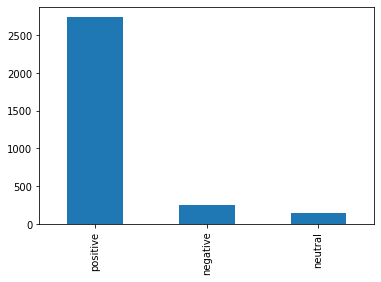

In [71]:
data['rating'].value_counts().plot(kind='bar')

Give a simple description of the class frequency distribution across the full dataset. What do you notice about the distribution? 

#### Task 1.2

To reduce computation time in this task, your will use only the 1000 most frequent tokens from the vocabulary as attributes. Run the code below to convert the input text samples into a document-term matrix:

In [72]:
vectorizer = CountVectorizer(analyzer=lambda x: x.split(), max_features=1000)

x_dense = vectorizer.fit_transform(data['verified_reviews'])
x_sparse = pd.DataFrame.sparse.from_spmatrix(x_dense, columns=vectorizer.get_feature_names())
x_sparse.head()

,!,!!,&,"&#34;Alexa,",&#34;Things,(which,",",-,--,.,...,worth,would,wouldn't,year,years,yet,yet.,you,you're,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It was written in the helper notebook that the original input representation is bad. Explain why a document-term matrix is a more suitable representation for machine learning tasks with text data.

Two variables *x_dense* and *x_sparce* both represent input data in a document-term form. Explain which one is preferable and why.

### Part 2 - Decision Tree [2 marks]

In this part you need to evaluate how classifier hyperparameters affect their performance. Consider a Decision Tree classifier that splits attributes based on the lowest entropy. For performance evaluation, assume that only the top 1000 most frequent tokens are used as attributes. The first 60% of samples should constitute the traing set while the remaining 40% of samples should constitute the test set.

#### Task 2.1
In the cell below place your code that computes performance measures for decision trees with different depth limits. <br> 
Consider the following cases: max_depth = 5, 10, 100, 200, None.

Decision tree with depth 5
              precision    recall  f1-score   support

    negative       0.38      0.18      0.24       102
     neutral       0.42      0.08      0.14        61
    positive       0.89      0.97      0.93      1097

    accuracy                           0.87      1260
   macro avg       0.56      0.41      0.44      1260
weighted avg       0.82      0.87      0.83      1260



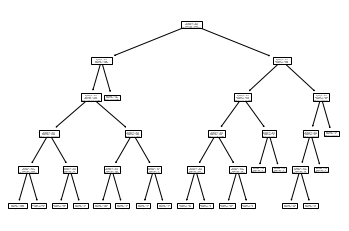

Decision tree with depth 10
              precision    recall  f1-score   support

    negative       0.42      0.17      0.24       102
     neutral       0.38      0.16      0.23        61
    positive       0.90      0.97      0.93      1097

    accuracy                           0.87      1260
   macro avg       0.57      0.44      0.47      1260
weighted avg       0.83      0.87      0.84      1260



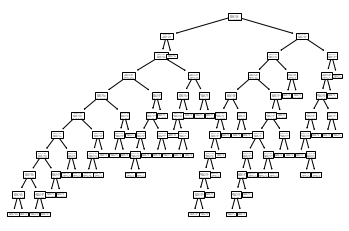

Decision tree with depth 100
              precision    recall  f1-score   support

    negative       0.38      0.31      0.34       102
     neutral       0.43      0.34      0.38        61
    positive       0.92      0.94      0.93      1097

    accuracy                           0.86      1260
   macro avg       0.57      0.53      0.55      1260
weighted avg       0.85      0.86      0.86      1260



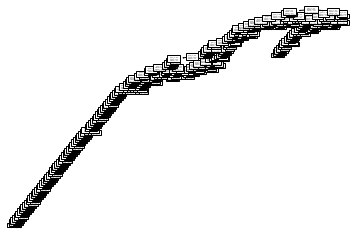

Decision tree with depth 200
              precision    recall  f1-score   support

    negative       0.44      0.35      0.39       102
     neutral       0.40      0.38      0.39        61
    positive       0.92      0.94      0.93      1097

    accuracy                           0.87      1260
   macro avg       0.59      0.56      0.57      1260
weighted avg       0.86      0.87      0.86      1260



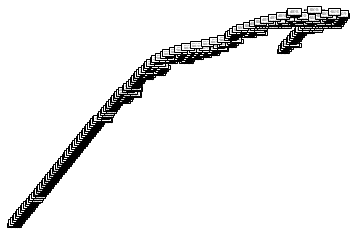

Decision tree with depth None
              precision    recall  f1-score   support

    negative       0.40      0.36      0.38       102
     neutral       0.41      0.43      0.42        61
    positive       0.92      0.93      0.92      1097

    accuracy                           0.86      1260
   macro avg       0.58      0.57      0.57      1260
weighted avg       0.85      0.86      0.86      1260



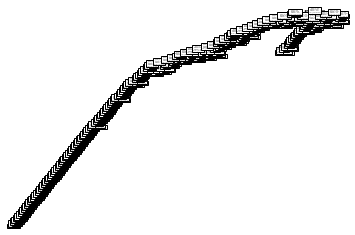

In [7]:
# your code

y = data['rating']
maxdepth = [5,10,100,200, None]
keys = [i for i in x_sparse]

X_train, X_test, y_train, y_test = train_test_split(x_sparse, y, train_size=0.6, test_size=0.4, random_state=1, shuffle=True) # 70% training and 30% test
for i in maxdepth:
    
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth = i)

    model = clf.fit(X_train, y_train)
    
    ytestpredicted = model.predict(X_test)
    
    
    tree.plot_tree(clf)
    print(f"Decision tree with depth {i}")
    print(classification_report(y_test, ytestpredicted))
    plt.show()

#### Task 2.2
In the cell below explain any difference in performance, and comment on metrics in relation to the depth limit.

### Part 3 - Pre-processing [3 marks]

In this part, you need to evaluate the effect that the pre-processing of input features has on the performance of three classifiers - Decision Tree (DT), Multinomial Naive Bayes (MNB), and  Artificial Neural Networks (ANN). For a Decision Tree classifier, use the parameters from Part2 but do not limit the depth. For a Artificial Neural Network classifier, set the number of hidden neurons to 200.

For the performance evaluation, assume that the first 60% of samples constitutes the traing set while the remaining 40% of samples constitutes the test set. All tokens in the vocabulary should be used as attributes.
Consider the following scenarios:
1. No data pre-processing
2. Removal of URLs and tokens that are not made of strings of letters, numbers, or symbols {’, #, @, $} delimited by spaces.
3. Apply (2) and make all tokens lowercase.
4. Apply (2), (3) and remove all stop words.

#### Task 3.1
In the cell below place your code that reflects the four scenarios of feature pre-processing.

In [76]:

# case 1
def preprocessing_1(x):
    return x

# case 2
def preprocessing_2(x):
    symbols = ["'", "#", "@", "$"]
    series = []
    for i in x:
        wordsArr = i.split()
        tmpSentence = []
        for j in range(len(wordsArr)):
            # Remove URLs
            if(wordsArr[j].endswith('.com')):
                continue
            # Remove tokens that are not letters, numbers or valid symbols
            tmpStr = ''
            for k in range(len(wordsArr[j])):
                if wordsArr[j][k].isalnum() or wordsArr[j][k] in symbols :
                    tmpStr = tmpStr +  wordsArr[j][k]
                else:
                    continue
            tmpSentence.append(tmpStr)
        series.append(' '.join(tmpSentence))
    series = pd.Series(series)
    return series

# case 3
def preprocessing_3(x):
    newSeries = preprocessing_2(x)
    series = []
    for i in newSeries:
        lower = i.lower()
        series.append(lower)
    newSeries = pd.Series(series)
    return newSeries

# case 4
def preprocessing_4(x):
    newSeries = preprocessing_3(x)
    
    cachedStopWords = stopwords.words('english')
    series = []
    for i in newSeries:
        series.append(' '.join([word for word in i.split() if word not in cachedStopWords]))
    series = pd.Series(series)
    return series



#### Task 3.2 

In the cell below, place your code that trains and tests all three classifiers. Pre-process your data according on scenario #4.

In [86]:
# your code   
x = preprocessing_4(data['verified_reviews'])

countvec =  CountVectorizer(analyzer=lambda x: x.split(), max_features=1000)

dense = countvec.fit_transform(data['verified_reviews'])
sparse = pd.DataFrame.sparse.from_spmatrix(dense, columns=countvec.get_feature_names())

y = data['rating']
xtrain, xtest, ytrain, ytest = train_test_split(sparse, y, train_size=0.6, test_size=0.4, random_state=1, shuffle=True) # 60% training and 40% test


print("Decision Tree")
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth = i)
model = clf.fit(xtrain, ytrain)
ytestpredicted = model.predict(xtest)
print(classification_report(ytest, ytestpredicted))



print("Multinomial Naive Bayes")
clf = MultinomialNB()
model = clf.fit(xtrain, ytrain)    
ytestpredicted = model.predict(xtest)
print(classification_report(ytest, ytestpredicted))


print("Artificial Neural Network")
clf = MLPClassifier(random_state=1, hidden_layer_sizes=200)
model = clf.fit(xtrain, ytrain)
ytestpredicted = model.predict(xtest)
print(classification_report(ytest, ytestpredicted))


Decision Tree
              precision    recall  f1-score   support

    negative       0.38      0.35      0.37       102
     neutral       0.35      0.38      0.37        61
    positive       0.92      0.92      0.92      1097

    accuracy                           0.85      1260
   macro avg       0.55      0.55      0.55      1260
weighted avg       0.85      0.85      0.85      1260

Multinomial Naive Bayes
              precision    recall  f1-score   support

    negative       0.54      0.49      0.52       102
     neutral       0.44      0.20      0.27        61
    positive       0.93      0.96      0.94      1097

    accuracy                           0.89      1260
   macro avg       0.64      0.55      0.58      1260
weighted avg       0.87      0.89      0.88      1260

Artificial Neural Network
              precision    recall  f1-score   support

    negative       0.61      0.37      0.46       102
     neutral       0.71      0.36      0.48        61
    positiv

#### Task 3.3

Evaluate the effect each pre-processing scenario has on the performance for the three models. In each case. compute the performance metrics. Write your answer in the cell below. 

## Part 4 [5 marks]

In this part, you need to evaluate how the number of features and classes affects the performance of the three classifiers - Decision Tree (DT), Multinomial Naive Bayes (MNB), and Artificial Neural Networks (ANN). For a Decision Tree classifier, use the parameters from Part 2 but do not limit the depth. For a Artificial Neural Network classifier set the number of hidden neurons to 200.

For the performance evaluation, assume that the first 60% of samples constitute the traing set while the remaining 40% of samples constitute the test set.

#### Task 4.1

Consider the following scenarios for attributes:

1. Attributes are all tokens in the vocabulary
2. Attributes are the top 1000 most frequent tokens in the vocabulary
3. Attributes are the top 100 most frequent tokens in the vocabulary
4. Attributes are the top 10 most frequent tokens in the vocabulary

In the cell below, place your code that returns a document-term representation given the number of attributes.

In [ ]:
# your code

def limit_attributes(x, n_attributes):
    return 

#### Task 4.2 

In the cell below, place your code that trains and tests all three classifiers. Limit the number of attributes according on scenario #4.

In [ ]:
# your code

#### Task 4.3

Evaluate the effect each scenario has on the performance for the three models based on the performance metrics. Explain the differences in the performance. Write your answer in the cell below.

#### Task 4.4

Remove all samples with neutral sentiment from the dataset. Train and test all three models on this new dataset, computing the preformance measures as well. Assume that the first 60% of samples constitute the traing set while the remaining 40% of samples constitute the test set. All tokens in the vocabulary should be used as attributes.

Place your code in the cell below.

In [ ]:
# your code

#### Task 4.5
Compare these results to the results obtained in scenario #1 (part 4). Is there any difference in the metrics for either of the classes (i.e. consider positive and negative classes individually)?

## Part 5 [8 marks]

In this part you need to develop your own method (pipeline) for sentiment analysis. You can create new code cells (to place your code) and Raw NBConvert cells (to descibe the steps you are taking to develop your model, or make a comment).

You can use either Decision Tree, Multinomial Naive Bayes (MNB), or Artificial Neural Network (ANN) classifiers. If you use parameters for your classifier, the you need to justify the values that you chose for them in writing or in coding & writing (if it is based on evaluation resuts) - similar to Part 2.

Since this part of the assignment carries the highest mark, the explanation of your method and its evaluation should be descibed in detail.

Optionally: you can also make plots to visualize your findings. 